In [1]:
import Colors

In [2]:
g_annotate = ['TBXT','NODAL','CDX2','RSPO3','SOX1','SOX2','WNT3a','FGF8','UNCX','TCF15','ALDH1A2',
            'MESP1','MESP2','RIPPLY2','DPPA5','GATA6','MEOX1','TBX6','CYP26A1','GATA4','HAND1','TBX1','PAX6',
            'ZEB2']

In [3]:
fchisb = ['../hG01-20umAP-120h-ChiSB43/mG01_trim_star_spliced.coutt.tsv', '../hG02-20umAP-120h-ChiSB43/mG02_trim_star_spliced.coutt.tsv']
fchi = ['../hG03-20umAP-72h-Chi/mG03_trim_star_spliced.coutt.tsv', '../hG04-20umAP-72h-Chi/mG04_trim_star_spliced.coutt.tsv']

fchisb_u = ['../hG01-20umAP-120h-ChiSB43/mG01_trim_star_unspliced.coutt.tsv', '../hG02-20umAP-120h-ChiSB43/mG02_trim_star_unspliced.coutt.tsv']
fchi_u = ['../hG03-20umAP-72h-Chi/mG03_trim_star_unspliced.coutt.tsv', '../hG04-20umAP-72h-Chi/mG04_trim_star_unspliced.coutt.tsv']

csbdf = [read_csv(f, sep = '\t', index_col=0) for f in fchisb]
chidf = [read_csv(f, sep = '\t', index_col=0) for f in fchi]

csbdf_U = [read_csv(f, sep = '\t', index_col=0) for f in fchisb_u]
chidf_U = [read_csv(f, sep = '\t', index_col=0) for f in fchi_u]

# remove suspicious genes

def removeGenes(df):
    genes = ['ERCC', 'Kcnq1ot1', 'Mir5109', 'Lars2','Malat1', 'Rn45s', 'RPL', 'RPS','__MT']
    exclude = [idx for idx in df.index for g in genes if g in idx]
    return df.loc[[idx for idx in df.index if idx not in exclude]]

def removeGmGenes(df):
    alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    numbers = [str(i) for i in range(10)]
    gmhumangenes = []
    for idx in df.index:
        g = idx.rsplit('_')[1]
        if all([x in alphabet for x in g[:2]]) and all([x in numbers for x in g[2:-2]]) and g[-2]=='.' and g[-1] in numbers:
            gmhumangenes.append(idx)
    return df.loc[[idx for idx in df.index if idx not in gmhumangenes]]

def removePeakyGenes(df):
    genes = []
    for idx in df.index:
        if sum(df.loc[idx]/df.loc[idx].sum()>=0.9)>=1: # and df.loc[idx].sum()<20:
            genes.append(idx)
    return df.loc[[idx for idx in df.index if idx not in genes]] # genes

fcsbdfs = [removePeakyGenes(removeGmGenes(removeGenes(df))) for df in csbdf]
fchidfs = [removePeakyGenes(removeGmGenes(removeGenes(df))) for df in chidf]

fcsbdfs_U = [removeGmGenes(removeGenes(df)) for df in csbdf_U]
fchidfs_U = [removeGmGenes(removeGenes(df)) for df in chidf_U]

# normalization

nfdfchis = [df.sum().mean()*df/df.sum() for df in fchidfs]
nfdfcsbs = [df.sum().mean()*df/df.sum() for df in fcsbdfs]

nfdfchis_U = [df.sum().mean()*df/df.sum() for df in fchidfs_U]
nfdfcsbs_U = [df.sum().mean()*df/df.sum() for df in fcsbdfs_U]

# z-score

def zscore(df):
    df = df.loc[df.index[df.sum(axis=1)>0]]
    zdf = df.T
    zdf = (zdf-zdf.mean())/zdf.std()
    zdf = zdf.T
    return zdf

def scalezscore(zdf):
    df  = ((zdf.T>=0)*zdf.T/zdf.max(axis=1) + (zdf.T<0)*zdf.T/abs(zdf.min(axis=1))).T
    return df

znfdfchis = [zscore(df) for df in nfdfchis]
sznfdfchis = [scalezscore(df) for df in znfdfchis]

znfdfcsbs = [zscore(df) for df in nfdfcsbs]
sznfdfcsbs = [scalezscore(df) for df in znfdfcsbs]

znfdfchis_U = [zscore(df) for df in nfdfchis_U]
sznfdfchis_U = [scalezscore(df) for df in znfdfchis_U]

znfdfcsbs_U = [zscore(df) for df in nfdfcsbs_U]
sznfdfcsbs_U = [scalezscore(df) for df in znfdfcsbs_U]

In [4]:
somcl_csb_df = read_csv('../../../WritingPapers/1stSubmission_Nature/code4figures/figHuman/som_hcl_ChiSB.txt', sep = '\t', index_col = 0)
somcl_chi_df = read_csv('../../../WritingPapers/1stSubmission_Nature/code4figures/figHuman/som_hcl_Chi.txt', sep = '\t', index_col = 0)

# fig 3c

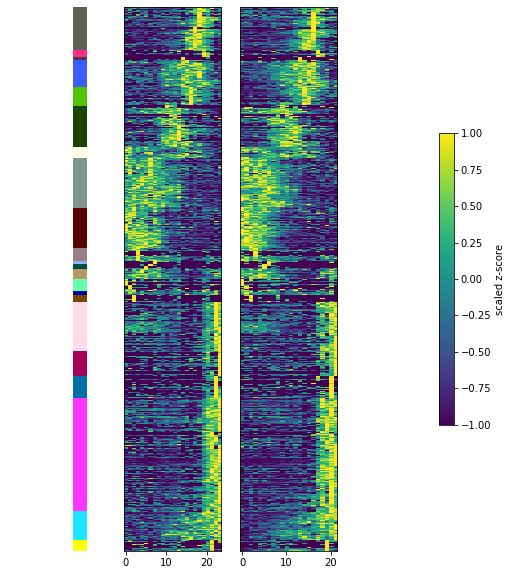

In [5]:
plt.figure(figsize=(8,10))

gene_order = somcl_chi_df.sort_values(by=['hcl','som']).index

plt.subplot(1,4,1, frameon = False)
y0 = 0; z0 = 0; xb = 4 # 3
for i in set(somcl_chi_df['hcl']):
    y = 1.0*somcl_chi_df[somcl_chi_df['hcl'] == i].shape[0]/somcl_chi_df.shape[0]
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(znfdfchis):
    plt.subplot(1,4,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
# plt.yticks(range(len(gene_order)), [g.rsplit('__')[0].rsplit('_')[-1] if g.rsplit('__')[0].rsplit('_')[-1] in annotate else '' for g in gene_order[::-1]])

plt.subplot(1,4, 4, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

# plt.savefig(path+'/heatmap_Chi_hSOM.pdf', bbox_inches = 'tight')
plt.show()

In [6]:
writer = pd.ExcelWriter('/Users/anna/Dropbox/gastruloids/WritingPapers/hGldPaper_Oct2019/source_data/fig2c.xlsx')

for i, df in enumerate(znfdfchis):
    df.loc[gene_order][::-1].to_excel(writer, sheet_name = 'z-score, hGld '+str(i+1))

writer.close()


In [7]:
# fig 3d

In [8]:
writer = pd.ExcelWriter('/Users/anna/Dropbox/gastruloids/WritingPapers/hGldPaper_Oct2019/source_data/fig2d.xlsx')

In [9]:
for cluster in [1, 2, 16, 18, 21]:
    xgs = somcl_chi_df[somcl_chi_df['hcl']==cluster].index
    for i, df in enumerate(znfdfchis):
        mu = df.loc[xgs].mean()
        mup = mu + df.loc[xgs].std()
        mum = mu - df.loc[xgs].std()
        xdf = pd.DataFrame({'mean': mu, 'var+': mup, 'var-': mum})
        xdf.to_excel(writer, sheet_name = 'clust.' + str(cluster) + ', hGld' + str(i+1))
    

In [10]:
writer.close()

In [11]:
# fig 3e

In [12]:
xgs = read_csv('../../../WritingPapers/1stSubmission_Nature/code4figures/figHuman/heatmap_germlayers_Alfonsoannotation_v2.txt', sep ='\t', index_col=0, header = None)

In [13]:
xgs = list(xgs[1])

In [14]:
writer = pd.ExcelWriter('/Users/anna/Dropbox/gastruloids/WritingPapers/hGldPaper_Oct2019/source_data/fig2e.xlsx')

for i, df in enumerate(znfdfchis):
    df.loc[xgs].to_excel(writer, sheet_name = 'z-score, hGld '+str(i+1))

writer.close()

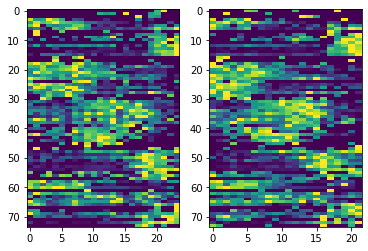

In [15]:
fig, ax = plt.subplots(ncols=2, nrows=1)
for i, df in enumerate(znfdfchis):
    ax[i].imshow(scalezscore(df.loc[xgs]), aspect = 'auto')
plt.show()

In [16]:
# fig 3f
# in 3_HoxGenes

In [17]:
# fig 4b

In [18]:
file = '/Users/anna/Dropbox/gastruloids/data/hGstl-tomo/results_postRevJan19/pooledAll_chichiSB45_normfilt.tsv'
ndf = read_csv(file, sep = '\t', index_col=0)

ndfs_chi = [ndf[[c for c in ndf.columns if g in c]] for g in ['hG01-chi', 'hG02-chi']]
#ndfs_sb = [ndf[[c for c in ndf.columns if g in c]] for g in ['hG03-sb', 'hG04-sb']]

In [19]:
def zscore(df):
    df = df.loc[df.index[df.sum(axis=1)>0]]
    zdf = df.T
    zdf = (zdf-zdf.mean())/zdf.std()
    zdf = zdf.T
    return zdf

def scalezscore(zdf):
    df  = ((zdf.T>=0)*zdf.T/zdf.max(axis=1) + (zdf.T<0)*zdf.T/abs(zdf.min(axis=1))).T
    return df

zdfs_chi = [zscore(df) for df in ndfs_chi]
#zdfs_sb = [zscore(df) for df in ndfs_sb]

In [20]:
def averageGastruloid(mzdf,n):
    mdf = mzdf.T
    glds = set(['-'.join(c.rsplit('-')[-2:]) for c in mdf.index])
    mdf['x'] = 0
    for gld in glds:
        idxs = [c for c in mdf.index if gld == '-'.join(c.rsplit('-')[-2:])]
        xra = np.linspace(0,1,len(idxs))
        for idx, x in zip(idxs, xra):
            mdf.loc[idx,'x'] = x
    mdf = mdf.sort_values(by = 'x', ascending = True)
    xdf = pd.DataFrame(columns = mdf.columns, index = range(n))
    xra = np.linspace(0,1,n+1)
    for i in range(len(xra)-1):
        idxs = [c for c in mdf.index if xra[i]<mdf.loc[c,'x']<=xra[i+1]]
        xdf.loc[i] = mdf.loc[idxs].mean()
    del xdf['x']
    return xdf.T

def mergeDfs(dfs):
    mdf = dfs[0]
    for i in range(1, len(dfs)):
        mdf = mdf.merge(dfs[i], how = 'outer', left_index = True, right_index = True)
    mdf = mdf.fillna(0)
    mdf = mdf.loc[mdf.sum(axis=1).sort_values(ascending=False).index]
    return mdf

mzdf_chi = mergeDfs(zdfs_chi)
#mzdf_sb = mergeDfs(zdfs_sb)

xdf_chi = averageGastruloid(mzdf_chi, min([len(df.columns) for df in zdfs_chi]))
#xdf_sb = averageGastruloid(mzdf_sb, min([len(df.columns) for df in zdfs_sb]))

xdf_chi = xdf_chi.astype(float)
#xdf_sb = xdf_sb.astype(float)


In [21]:
writer = pd.ExcelWriter('/Users/anna/Dropbox/gastruloids/WritingPapers/hGldPaper_Oct2019/source_data/fig4b.xlsx')
xgs = ['ENSG00000154342_WNT3A__1', 'ENSG00000107831_FGF8__10', 'ENSG00000128918_ALDH1A2__15']
xdf_chi.loc[xgs].T.to_excel(writer, sheet_name = 'heatmap')
writer.close()

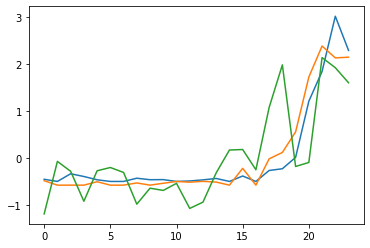

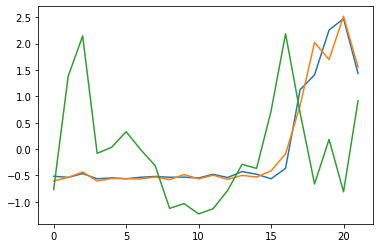

In [22]:
xgs = ['ENSG00000164458_TBXT__6','ENSG00000165556_CDX2__13','ENSG00000181449_SOX2__3']
for x in xgs:
    plt.plot(range(len(znfdfchis[0].columns)), znfdfchis[0].loc[x])
plt.show()
for x in xgs:
    plt.plot(range(len(znfdfchis[1].columns)), znfdfchis[1].loc[x])
plt.show()

In [23]:
# fig 4d

In [24]:
writer = pd.ExcelWriter('/Users/anna/Dropbox/gastruloids/WritingPapers/hGldPaper_Oct2019/source_data/fig4d.xlsx')
xgs = ['ENSG00000243709_LEFTY1__1', 'ENSG00000143768_LEFTY2__1', 'ENSG00000156574_NODAL__10']
xdf_chi.loc[xgs].T.to_excel(writer, sheet_name = 'heatmap')
writer.close()

In [25]:
[idx for idx in xdf_chi.index if 'FGF10' in idx ]

['ENSG00000248464_FGF10-AS1__5', 'ENSG00000070193_FGF10__5']

In [26]:
# fig 4h

In [27]:
writer = pd.ExcelWriter('/Users/anna/Dropbox/gastruloids/WritingPapers/hGldPaper_Oct2019/source_data/fig4h.xlsx')
xgs = ['ENSG00000183072_NKX2-5__5', 'ENSG00000164107_HAND2__4', 'ENSG00000125845_BMP2__20','ENSG00000070193_FGF10__5']
xdf_chi.loc[xgs].T.to_excel(writer, sheet_name = 'heatmap')
writer.close()

In [28]:
# fig 5f

In [29]:
# fig 6a

In [30]:
somhcl_chiL_df = read_csv('../../Lnfg-mGst-tomo/results/comparison_Lfng_human_gastruloids/heatmap_ReprChiLfng_averages.tsv', sep = '\t', index_col=0)

In [31]:
somhcl_chiL_df.head()

,som,hcl,orto
ENSG00000166250_CLMP,79,11,Clmp
ENSG00000143870_PDIA6,33,23,Pdia6
ENSG00000179915_NRXN1,58,10,Nrxn1
ENSG00000120075_HOXB5,31,20,Hoxb5
ENSG00000167601_AXL,86,10,Axl


In [32]:
xdf_L = read_csv('../av_mouseGld.tsv', sep = '\t', index_col = 0)
xdf_chi = read_csv('../av_humanGld_chi.tsv', sep = '\t', index_col = 0)
xdf_sb = read_csv('../av_humanGld_chiSB43.tsv', sep = '\t', index_col = 0)

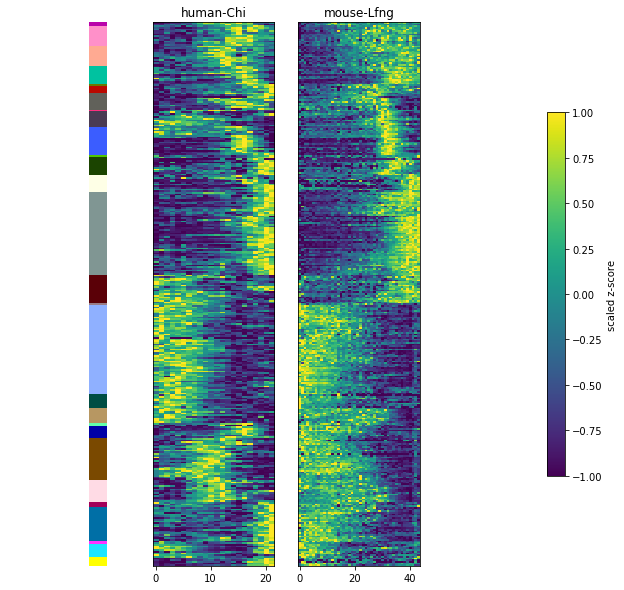

In [33]:
plt.figure(figsize=(10,10))

jidx = 1
hcldf = somhcl_chiL_df
gene_order = hcldf.sort_values(by=['hcl','som']).index
Npl = 2+2
plt.subplot(1,Npl,1, frameon = False)
titles = ['human-Chi','mouse-Lfng']

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(hcldf['hcl']):
    y = 1.0*len(hcldf[hcldf['hcl'] == i])/len(hcldf)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate([xdf_chi, xdf_L]):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1].astype(float)), aspect = 'auto')
    plt.yticks([])
    plt.title(titles[i])
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 5, left = False, right = True)
#plt.yticks([i for i, g in enumerate(gene_order[::-1]) if np.mod(i,10)==jidx], [g.rsplit('_')[1]+' / '+ortos_h2m.loc[g,'mouse'].rsplit('_')[-1] for i, g in enumerate(gene_order[::-1]) if np.mod(i,10)==jidx])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.show()

In [34]:
writer = pd.ExcelWriter('/Users/anna/Dropbox/gastruloids/WritingPapers/hGldPaper_Oct2019/source_data/fig6a.xlsx')


title = ['human','mouse']                    
for i, df in enumerate([xdf_chi, xdf_L]):
    df.loc[gene_order][::-1].astype(float).to_excel(writer, sheet_name = title[i])

writer.close()

In [35]:
# EDF5a
# in 1_split-rawdata

In [36]:
# EDF5b

In [37]:
writer = pd.ExcelWriter('/Users/anna/Dropbox/gastruloids/WritingPapers/hGldPaper_Oct2019/source_data/edf1b.xlsx')

for cluster in set(somcl_chi_df['hcl']):
    xgs = somcl_chi_df[somcl_chi_df['hcl']==cluster].index
    for i, df in enumerate(znfdfchis):
        mu = df.loc[xgs].mean()
        mup = mu + df.loc[xgs].std()
        mum = mu - df.loc[xgs].std()
        xdf = pd.DataFrame({'mean': mu, 'var+': mup, 'var-': mum})
        xdf.to_excel(writer, sheet_name = 'clust.' + str(cluster) + ', hGld' + str(i+1))
    
writer.close()

In [38]:
# EDF5c

In [39]:
genes = ['MEOX1', 'ISL1', 'FGF10','FGFR1','MEF2C','TBX5','CHRD', 'HOXA1','LFNG','FGF8','HAND1', 'FOXA2','BMP2',
         'TCF15','ALDH1A2','NOTCH2','GATA4','GATA6','LEFTY2','CER1','NOTCH1','EDNRA','WNT3A','NODAL','FGFR4',
         'PITX2','HAND2','TBXT','CDX2','MESP1','SIX2','DAND5','SOX2','NKX2-5','TBX1','PTCH1','MESP2','DLL1','NOTO',
         'LEFTY1']

In [40]:
genes = [idx for idx in znfdfchis[0].index if idx.rsplit('_')[1] in genes]

In [41]:
writer = pd.ExcelWriter('/Users/anna/Dropbox/gastruloids/WritingPapers/hGldPaper_Oct2019/source_data/edf1c.xlsx')

znfdfchis[0].loc[genes].to_excel(writer, sheet_name = 'hGld 1')
znfdfchis[1].loc[genes].to_excel(writer, sheet_name = 'hGld 2')

writer.close()

In [42]:
# EDF 6a

In [43]:
genes = ['EGR2','EMX1','EMX2','EN1','EN2','FGF5','KRT5','KRT8','KRT15','KRT18','TBR1','WNT1','SIX3',
        'HESX1','FOXG1','POU3F1','OTX1','OTX2','GBX2','EPHB2','EPHB3','FOXB1']

In [44]:
xgs = []
for g in genes:
    if g in [idx.rsplit("_")[1] for idx in znfdfchis[0].index]+[idx.rsplit("_")[1] for idx in znfdfchis[1].index]:
        kk = [idx for idx in znfdfchis[0].index if idx.rsplit('_')[1]==g] + [idx for idx in znfdfchis[1].index if idx.rsplit('_')[1]==g]
        xgs.append(kk[0])
    else:
        xgs.append(g)

In [45]:
writer = pd.ExcelWriter('/Users/anna/Dropbox/gastruloids/WritingPapers/hGldPaper_Oct2019/source_data/edf6a.xlsx')

ndfs_chi[0].loc[xgs].fillna(0).to_excel(writer, sheet_name = 'hGld 1')
ndfs_chi[1].loc[xgs].fillna(0).to_excel(writer, sheet_name = 'hGld 2')

writer.close()

/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


# EDF6b

In [46]:
hoxes = []
for hox in ['HOXA','HOXB','HOXC','HOXD']:
    for j in range(1,14):
        kk = [idx for idx in set(list(ndfs_chi[0].index)+list(ndfs_chi[1].index)) if hox + str(j) + '_' in idx ]
        if len(kk)>0:
            hoxes.append(kk[0])
        

In [47]:
writer = pd.ExcelWriter('/Users/anna/Dropbox/gastruloids/WritingPapers/hGldPaper_Oct2019/source_data/edf6b.xlsx')

ndfs_chi[0].loc[hoxes].to_excel(writer, sheet_name = 'hGld 1')
ndfs_chi[1].loc[hoxes].to_excel(writer, sheet_name = 'hGld 2')

writer.close()

In [48]:
# edf6 c

In [49]:
genes = ['BMPR2','BMP3','BMP6','BMP7','BMP1','BMP2K','BMPR1A','BMP2','BMP4','BMPER','BMP5','BMPR1B']

In [50]:
xgs = []
for g in genes:
    if g in [idx.rsplit("_")[1] for idx in znfdfchis[0].index]+[idx.rsplit("_")[1] for idx in znfdfchis[1].index]:
        kk = [idx for idx in znfdfchis[0].index if idx.rsplit('_')[1]==g] + [idx for idx in znfdfchis[1].index if idx.rsplit('_')[1]==g]
        xgs.append(kk[0])
    else:
        xgs.append(g)

In [51]:
writer = pd.ExcelWriter('/Users/anna/Dropbox/gastruloids/WritingPapers/hGldPaper_Oct2019/source_data/edf6c.xlsx')

znfdfchis[0].loc[xgs].to_excel(writer, sheet_name = 'hGld 1, top')
znfdfchis[1].loc[xgs].to_excel(writer, sheet_name = 'hGld 2, top')

In [52]:
genes = ['WNT2B','WNT11','WNT4','WNT9A','WNT5A','WNT3A','WNT5B','WNT3']

In [53]:
xgs = []
for g in genes:
    if g in [idx.rsplit("_")[1] for idx in znfdfchis[0].index]+[idx.rsplit("_")[1] for idx in znfdfchis[1].index]:
        kk = [idx for idx in znfdfchis[0].index if idx.rsplit('_')[1]==g] + [idx for idx in znfdfchis[1].index if idx.rsplit('_')[1]==g]
        xgs.append(kk[0])
    else:
        xgs.append(g)

In [54]:
xgs

['ENSG00000134245_WNT2B__1',
 'ENSG00000085741_WNT11__11',
 'ENSG00000162552_WNT4__1',
 'ENSG00000143816_WNT9A__1',
 'ENSG00000114251_WNT5A__3',
 'ENSG00000154342_WNT3A__1',
 'ENSG00000111186_WNT5B__12',
 'ENSG00000108379_WNT3__17']

In [55]:
znfdfchis[0].loc[xgs].to_excel(writer, sheet_name = 'hGld 1, bottom')
znfdfchis[1].loc[xgs].to_excel(writer, sheet_name = 'hGld 2, bottom')

In [56]:
writer.close()

In [57]:
# EDF6h

In [58]:
genes = ['LEFTY1','DAND5','SHH','NODAL','CER1','LEFTY2','GDF1']

In [59]:
xgs = []
for g in genes:
    if g in [idx.rsplit("_")[1] for idx in znfdfchis[0].index]+[idx.rsplit("_")[1] for idx in znfdfchis[1].index]:
        kk = [idx for idx in znfdfchis[0].index if idx.rsplit('_')[1]==g] + [idx for idx in znfdfchis[1].index if idx.rsplit('_')[1]==g]
        xgs.append(kk[0])
    else:
        xgs.append(g)

In [60]:
writer = pd.ExcelWriter('/Users/anna/Dropbox/gastruloids/WritingPapers/hGldPaper_Oct2019/source_data/edf6h.xlsx')

znfdfchis[0].loc[xgs].to_excel(writer, sheet_name = 'hGld 1')
znfdfchis[1].loc[xgs].to_excel(writer, sheet_name = 'hGld 2')

writer.close()

In [61]:
# EDF 7b

In [62]:
somhcl_SB_df = read_csv('../results_postRevJan19/final_figs/heatmap_chisb43.tsv', sep = '\t', index_col=0)

In [63]:
mdfsSB = [read_csv('../SB43_gld1_zscore.tsv', sep = '\t', index_col = 0), 
          read_csv('../SB43_gld2_zscore.tsv', sep = '\t', index_col = 0)]
mdfSB_av = read_csv('../SB43_average_zscore.tsv', sep = '\t', index_col = 0)

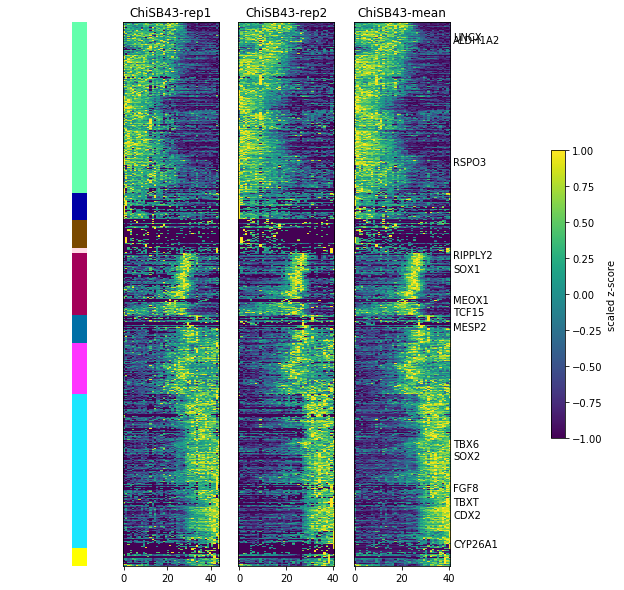

In [233]:
plt.figure(figsize=(10,10))

gene_order = somhcl_SB_df.sort_values(by=['hcl','som']).index
Npl = 3+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(somhcl_SB_df['hcl']):
    y = 1.0*len(somhcl_SB_df[somhcl_SB_df['hcl'] == i])/len(somhcl_SB_df)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

titles = ['ChiSB43-rep1', 'ChiSB43-rep2', 'ChiSB43-mean']
for i, df in enumerate(mdfsSB + [mdfSB_av]):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
    plt.title(titles[i])
plt.tick_params(axis='y', labelleft=False, labelright='on', length = 0)
plt.yticks(range(len(gene_order)), [g.rsplit('_')[1] if g.rsplit('_')[1] in g_annotate else '' for g in gene_order[::-1]])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.show()

In [65]:
writer = pd.ExcelWriter('/Users/anna/Dropbox/gastruloids/WritingPapers/hGldPaper_Oct2019/source_data/edf7b.xlsx')

gene_order = somhcl_SB_df.sort_values(by=['hcl','som']).index
titles = ['chiSB43-gld1', 'chiSB43-gld2', 'chiSB43-average']
for i, df in enumerate(mdfsSB + [mdfSB_av]):
    df.loc[gene_order][::-1].to_excel(writer, sheet_name = titles[i])

writer.close()

In [235]:
# EDF6 c

In [236]:
set(somhcl_SB_df['hcl'])

{0, 1, 2, 3, 4, 5, 6, 7, 8}

In [237]:
writer = pd.ExcelWriter('/Users/anna/Dropbox/gastruloids/WritingPapers/hGldPaper_Oct2019/source_data/edf7c.xlsx')

for cluster in set(somhcl_SB_df['hcl']):
    xgs = somhcl_SB_df[somhcl_SB_df['hcl']==cluster].index
    for i, df in enumerate(mdfsSB):
        mu = df.loc[xgs].mean()
        mup = mu + df.loc[xgs].std()
        mum = mu - df.loc[xgs].std()
        xdf = pd.DataFrame({'mean': mu, 'var+': mup, 'var-': mum})
        xdf.to_excel(writer, sheet_name = 'clust.' + str(cluster) + ', chiSB43-gld ' + str(i+1))
    
writer.close()

In [ ]:
# EDF7d

In [240]:
zdfs_L_ortos = [
    read_csv('../../hGstl-tomo/mGld1_zscore.tsv', sep = '\t', index_col = 0),
    read_csv('../../hGstl-tomo/mGld2_zscore.tsv', sep = '\t', index_col = 0),
    read_csv('../../hGstl-tomo/mGld3_zscore.tsv', sep = '\t', index_col = 0)]

In [243]:
somhcl_L_noreprchi_noexprchi_df = read_csv('../../Lnfg-mGst-tomo/results/comparison_Lfng_human_gastruloids/heatmap_ReprLfng_noReprChi_noExprChi.tsv', sep = '\t', index_col=0)

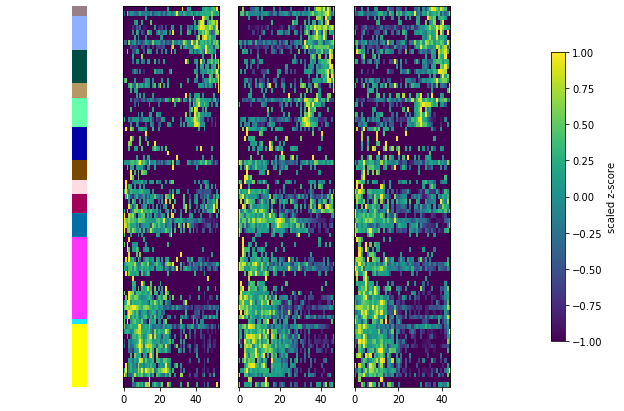

In [246]:
plt.figure(figsize=(10,7))

hcldf = somhcl_L_noreprchi_noexprchi_df
gene_order = hcldf.sort_values(by=['hcl','som']).index
Npl = len(zdfs_L_ortos)+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(hcldf['hcl']):
    y = 1.0*len(hcldf[hcldf['hcl'] == i])/len(hcldf)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(zdfs_L_ortos):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 4, left = False, right = True)

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.show()

In [247]:
writer = pd.ExcelWriter('/Users/anna/Dropbox/gastruloids/WritingPapers/hGldPaper_Oct2019/source_data/edf8b.xlsx')

hcldf = somhcl_L_noreprchi_noexprchi_df
gene_order = hcldf.sort_values(by=['hcl','som']).index
for i, df in enumerate(zdfs_L_ortos):
    df.loc[gene_order][::-1].to_excel(writer, sheet_name = 'mGld '+str(i+1))

writer.close()

In [ ]:
# edf 8d

In [258]:
somhcl_L_noreprchi_exprchi_df = read_csv('../../Lnfg-mGst-tomo/results/comparison_Lfng_human_gastruloids/heatmap_ReprLfng_noReprChi_ExprChi.tsv', sep = '\t', index_col=0)

In [259]:
zdfs_chi = [
    read_csv('../hGld1_chi_zscore.tsv', sep = '\t', index_col=0), 
    read_csv('../hGld2_chi_zscore.tsv', sep = '\t', index_col = 0)]


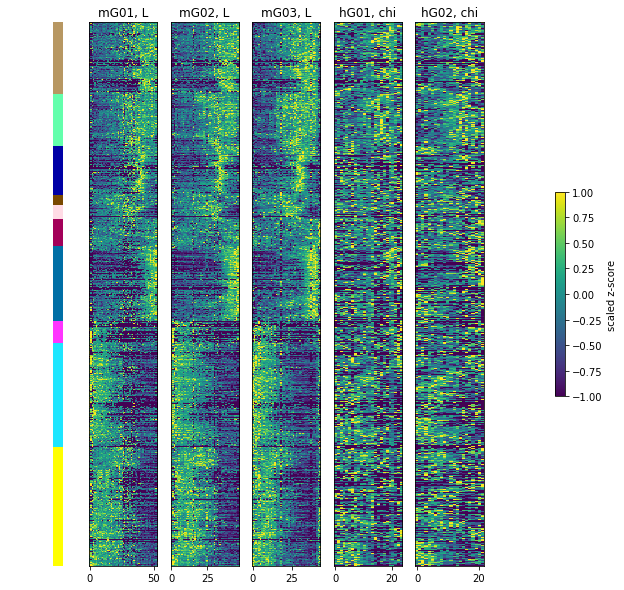

In [263]:
plt.figure(figsize=(10,10))

jidx = 1
hcldf = somhcl_L_noreprchi_exprchi_df
gene_order = hcldf.sort_values(by=['hcl','som']).index
Npl = len(zdfs_L_ortos+zdfs_chi)+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(hcldf['hcl']):
    y = 1.0*len(hcldf[hcldf['hcl'] == i])/len(hcldf)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(zdfs_L_ortos+zdfs_chi):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
    plt.title(', '.join(df.columns[0].rsplit('-')[1:]))
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 5, left = False, right = True)
plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.show()

In [264]:
writer = pd.ExcelWriter('/Users/anna/Dropbox/gastruloids/WritingPapers/hGldPaper_Oct2019/source_data/edf8d.xlsx')

title = ['mGld1',' mGld2','mGld3','hGld1','hGld2']
for i, df in enumerate(zdfs_L_ortos+zdfs_chi):

    df.loc[gene_order][::-1].to_excel(writer, sheet_name = title[i])

writer.close()

In [265]:
# edf8c

In [266]:
somhcl_chi_noReprL_noExprL_df = read_csv('../../Lnfg-mGst-tomo/results/comparison_Lfng_human_gastruloids/heatmap_ReprChi_noReprLfng_noExprLfng.tsv', sep = '\t', index_col=0)

In [267]:
writer = pd.ExcelWriter('/Users/anna/Dropbox/gastruloids/WritingPapers/hGldPaper_Oct2019/source_data/edf8c.xlsx')

jidx = 1
hcldf = somhcl_chi_noReprL_noExprL_df
gene_order = hcldf.sort_values(by=['hcl','som']).index

for i, df in enumerate(zdfs_chi):
    df.loc[gene_order][::-1].to_excel(writer, sheet_name = 'hGld' + str(i+1))

writer.close()

In [268]:
# edf 8e

In [269]:
somhcl_chi_noReprL_noExprL_df = read_csv('../../Lnfg-mGst-tomo/results/comparison_Lfng_human_gastruloids/heatmap_ReprChi_noReprL_ExprL.tsv', index_col=0, sep = '\t')

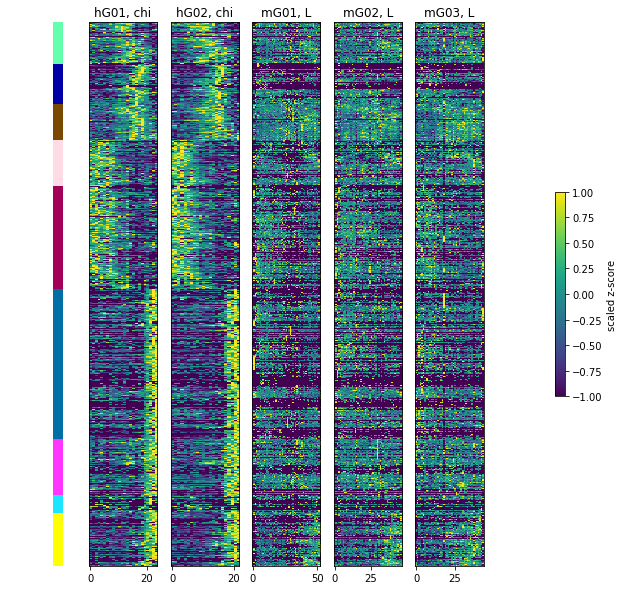

In [272]:
plt.figure(figsize=(10,10))

jidx = 1
hcldf = somhcl_chi_noReprL_noExprL_df
gene_order = hcldf.sort_values(by=['hcl','som']).index
Npl = len(zdfs_chi+zdfs_L_ortos)+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(hcldf['hcl']):
    y = 1.0*len(hcldf[hcldf['hcl'] == i])/len(hcldf)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(zdfs_chi+zdfs_L_ortos):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
    plt.title(', '.join(df.columns[0].rsplit('-')[1:]))
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 5, left = False, right = True)

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.show()

In [273]:
writer = pd.ExcelWriter('/Users/anna/Dropbox/gastruloids/WritingPapers/hGldPaper_Oct2019/source_data/edf8e.xlsx')

jidx = 1
hcldf = somhcl_chi_noReprL_noExprL_df
gene_order = hcldf.sort_values(by=['hcl','som']).index
title = ['hGld1','hGld2','mGld1','mGld2','mGld3']
for i, df in enumerate(zdfs_chi+zdfs_L_ortos):
    df.loc[gene_order][::-1].to_excel(writer, sheet_name = title[i])
    
writer.close()